In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import random
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Kullanılan Cihaz: cuda


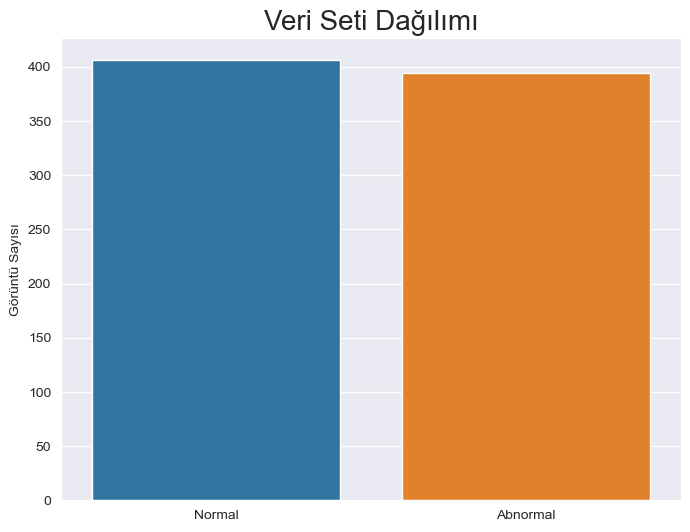

   Normal  Abnormal
0     406       394


In [2]:
DATA_DIR = './archive/data'
IMAGE_DIR = os.path.join(DATA_DIR, "Lung Segmentation/CXR_png")

all_filenames = os.listdir(IMAGE_DIR)

normal_count = len([f for f in all_filenames if f.endswith('_0.png')])
abnormal_count = len([f for f in all_filenames if f.endswith('_1.png')])

dist_df = pd.DataFrame.from_dict({
    'Normal': [normal_count], 
    'Abnormal': [abnormal_count]
})

plt.figure(figsize=(8,6))
sns.barplot(data=dist_df)
plt.title('Veri Seti Dağılımı', fontsize=20)
plt.ylabel('Görüntü Sayısı')
plt.show()

print(dist_df)

In [3]:
MASK_DIR = os.path.join(DATA_DIR, "Lung Segmentation/masks")

all_images = sorted(os.listdir(IMAGE_DIR))
all_masks = sorted(os.listdir(MASK_DIR))

print(f"Toplam Resim: {len(all_images)}")
print(f"Toplam Maske: {len(all_masks)}")

valid_images = []
valid_masks = []

mask_set = set(all_masks) 

for img_name in all_images:
    if img_name in mask_set:
        valid_images.append(img_name)
        valid_masks.append(img_name)
        continue

    name_no_ext = os.path.splitext(img_name)[0]
    potential_mask_name = name_no_ext + "_mask.png"
    
    if potential_mask_name in mask_set:
        valid_images.append(img_name)
        valid_masks.append(potential_mask_name)

print(f"Kullanılacak Veri Sayısı: {len(valid_images)}")

images_train, images_val, masks_train, masks_val = train_test_split(
    valid_images, valid_masks, test_size=0.2, random_state=42
)

print(f"Eğitim Seti: {len(images_train)}")
print(f"Doğrulama Seti: {len(images_val)}")

Toplam Resim: 800
Toplam Maske: 704
Kullanılacak Veri Sayısı: 704
Eğitim Seti: 563
Doğrulama Seti: 141


In [4]:
class ChestXraySegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_list, mask_list, transform=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_list = image_list
        self.mask_list = mask_list
        self.transform = transform
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        mask_name = self.mask_list[idx]
        
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        # DATA AUGMENTATION        
        image = TF.resize(image, (256, 256))
        mask = TF.resize(mask, (256, 256), interpolation=transforms.InterpolationMode.NEAREST)
        
        if self.transform:
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

            if random.random() > 0.5:
                angle = random.randint(-10, 10) 
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle)

        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        mask = (mask > 0).float()
        
        return image, mask

train_dataset = ChestXraySegmentationDataset(IMAGE_DIR, MASK_DIR, images_train, masks_train, transform=True)
val_dataset = ChestXraySegmentationDataset(IMAGE_DIR, MASK_DIR, images_val, masks_val, transform=False)

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False)

Eğitim Verisinden Örnekler:


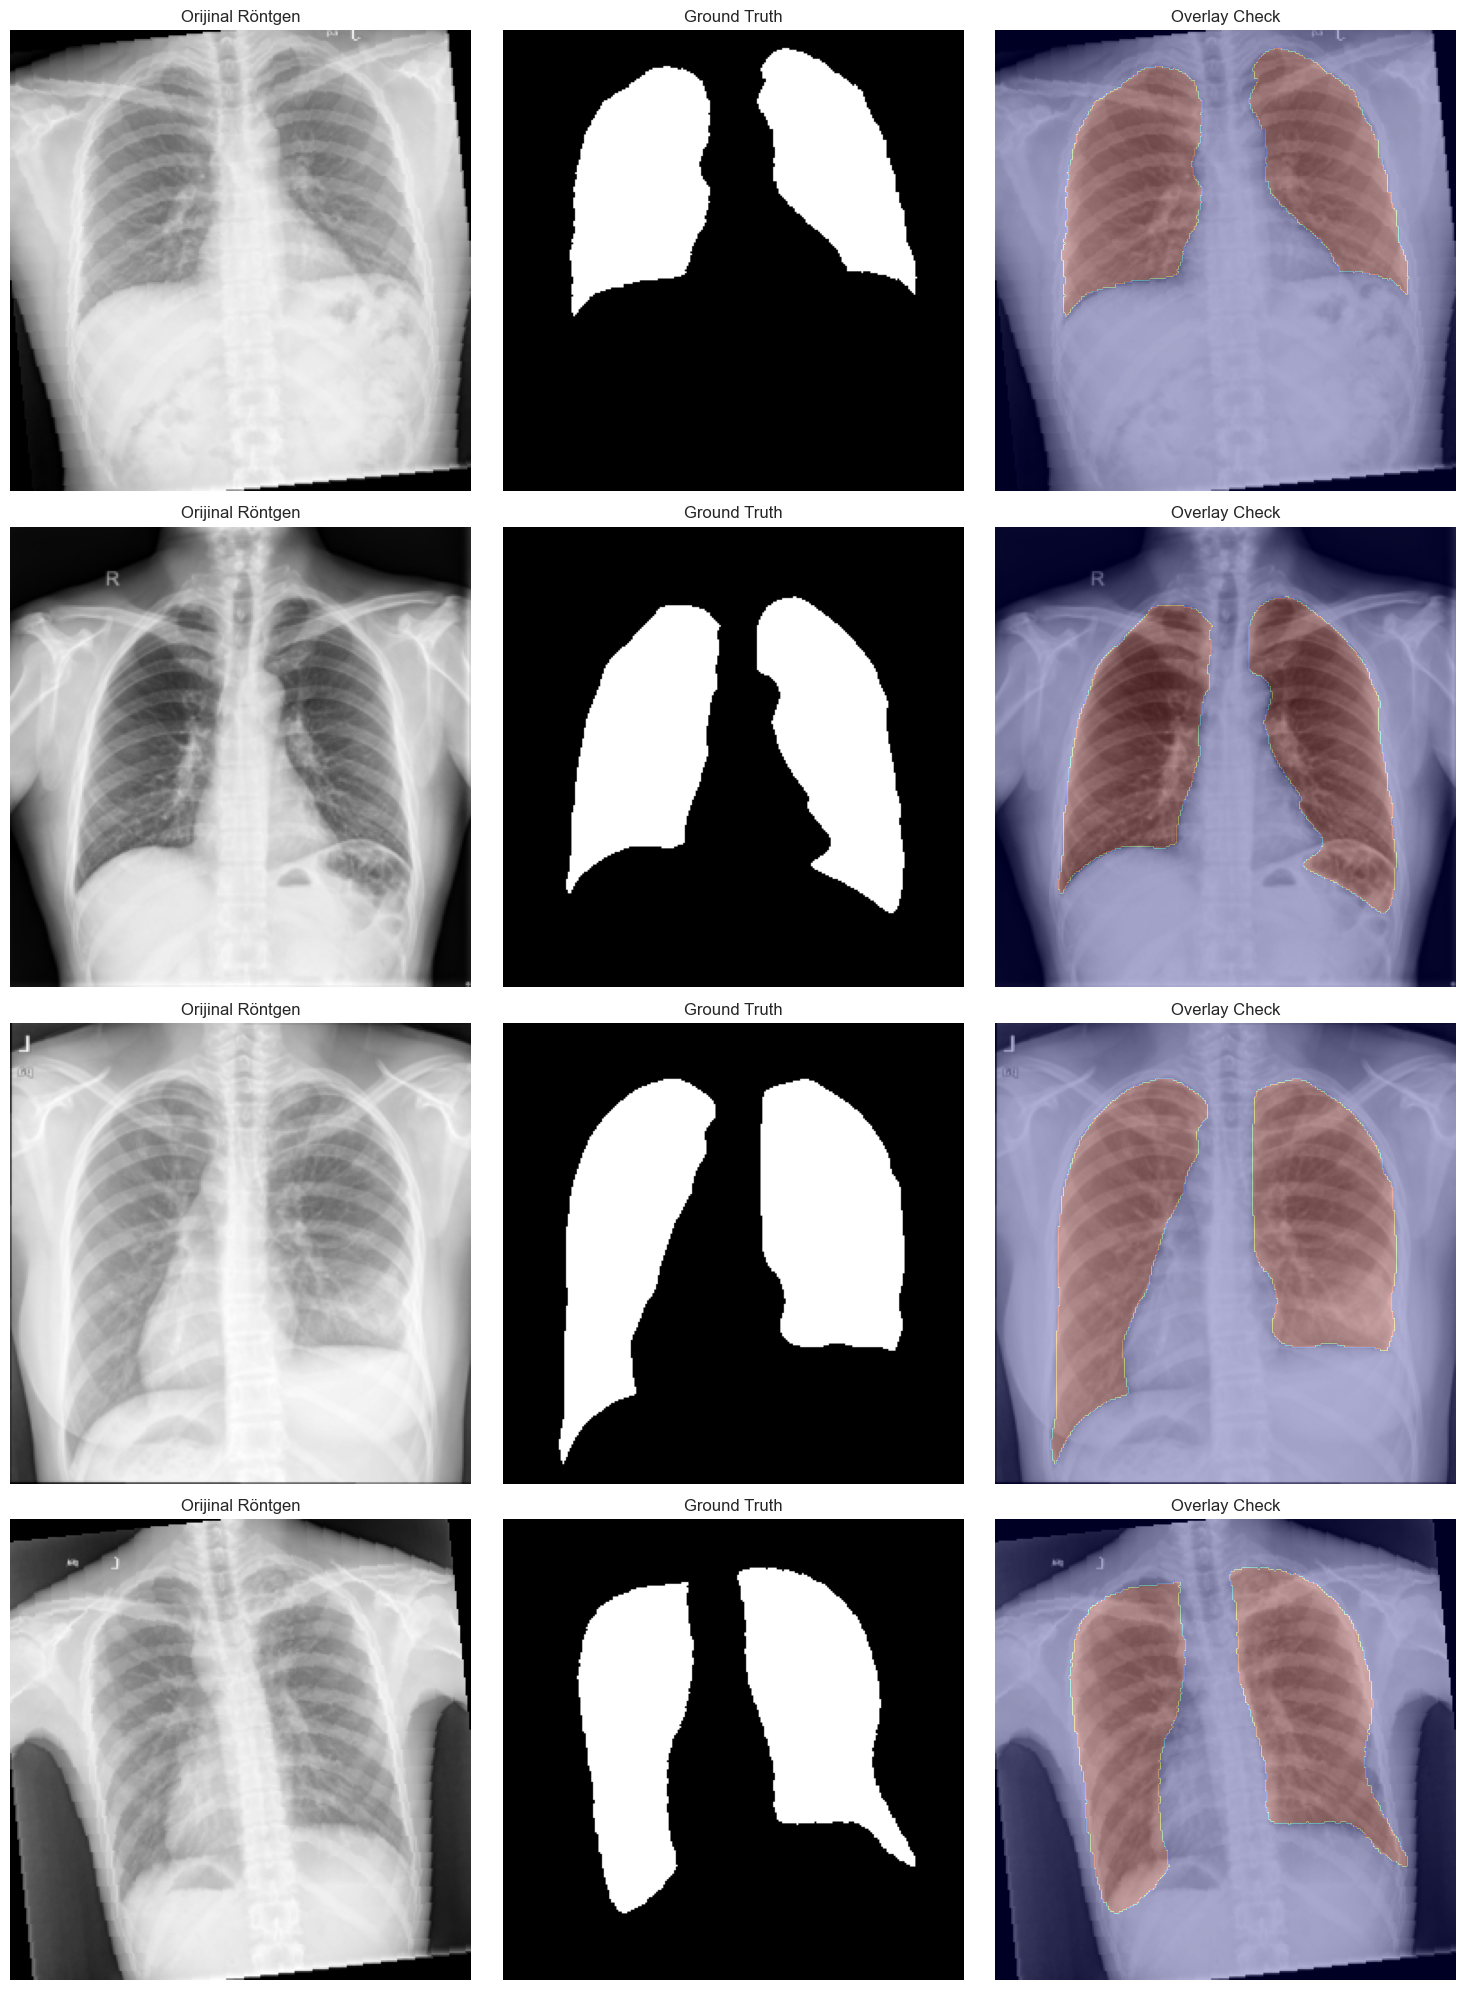

In [6]:
def visualize_dataset(loader, num_samples=5):
    images, masks = next(iter(loader))
    batch_size = images.shape[0]

    if num_samples > batch_size:
        print(f"Uyarı: İstenen {num_samples} örnek batch boyutundan ({batch_size}) fazla. Sadece {batch_size} adet gösterilecek.")
        num_samples = batch_size

    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        img = images[i].squeeze().numpy()
        msk = masks[i].squeeze().numpy()
        
        # 1. Orijinal Röntgen
        if num_samples == 1:
            ax0, ax1, ax2 = axs[0], axs[1], axs[2]
        else:
            ax0, ax1, ax2 = axs[i, 0], axs[i, 1], axs[i, 2]

        ax0.imshow(img, cmap='gray')
        ax0.set_title("Orijinal Röntgen")
        ax0.axis('off')
        
        # 2. Ground Truth
        ax1.imshow(msk, cmap='gray')
        ax1.set_title("Ground Truth")
        ax1.axis('off')
        
        # 3. Overlay
        ax2.imshow(img, cmap='gray')
        ax2.imshow(msk, cmap='jet', alpha=0.3) 
        ax2.set_title("Overlay Check")
        ax2.axis('off')
        
    plt.tight_layout()
    plt.show()

print("Eğitim Verisinden Örnekler:")
visualize_dataset(train_loader, num_samples=4)

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [8]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        
        # Gate signal
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        # Input signal
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        # Psi
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='bilinear', align_corners=True)
        
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        return x * psi

In [9]:
class AttentionUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(AttentionUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # ENCODER
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))
        
        # DECODER
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=512, F_l=512, F_int=256) # <--- YENİ: Attention 1
        self.conv1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=256, F_l=256, F_int=128) # <--- YENİ: Attention 2
        self.conv2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=128, F_l=128, F_int=64)  # <--- YENİ: Attention 3
        self.conv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=64, F_l=64, F_int=32)    # <--- YENİ: Attention 4
        self.conv4 = DoubleConv(128, 64)
        
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # ENCODER
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # DECODER (with attention)
        d5 = self.up1(x5)
        x4 = self.att1(g=d5, x=x4) 
        d5 = torch.cat([x4, d5], dim=1)
        d5 = self.conv1(d5)

        d4 = self.up2(d5)
        x3 = self.att2(g=d4, x=x3)
        d4 = torch.cat([x3, d4], dim=1)
        d4 = self.conv2(d4)

        d3 = self.up3(d4)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.cat([x2, d3], dim=1)
        d3 = self.conv3(d3)

        d2 = self.up4(d3)
        x1 = self.att4(g=d2, x=x1) 
        d2 = torch.cat([x1, d2], dim=1)
        d2 = self.conv4(d2)
        
        logits = self.outc(d2)
        return logits

In [10]:
model = AttentionUNet(n_channels=1, n_classes=1).to(device)

print("Attention UNet modeli oluşturuldu.")

Attention UNet modeli oluşturuldu.


In [11]:
class ComboLoss(nn.Module):
    def __init__(self, smooth=1):
        super(ComboLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        dice_loss = 1 - dice

        bce = F.binary_cross_entropy(inputs, targets, reduction='mean')

        return bce + dice_loss

In [12]:
LEARNING_RATE = 1e-3  
EPOCHS = 20           

criterion = ComboLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5, verbose=True
)

def calculate_dice_score(pred_logits, targets):
    preds = torch.sigmoid(pred_logits)
    preds = (preds > 0.5).float()
    
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()

    dice = (2. * intersection + 1e-5) / (union + 1e-5)
    return dice.item()

/home/mercan/anaconda3/envs/densenet_pytorch/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
# TRAIN
history = {
    'train_loss': [],
    'val_loss': [],
    'train_dice': [],
    'val_dice': []
}

best_val_loss = float('inf') 

print("Eğitim başlıyor.")

for epoch in range(EPOCHS):
    # TRAIN
    model.train()
    train_loss = 0
    train_dice = 0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += calculate_dice_score(outputs, masks)

    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice / len(train_loader)
    
    # VAL
    model.eval()
    val_loss = 0
    val_dice = 0
    
    with torch.no_grad(): 
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            val_loss += loss.item()
            val_dice += calculate_dice_score(outputs, masks)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_dice'].append(avg_train_dice)
    history['val_dice'].append(avg_val_dice)

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        save_msg = "-> Model Kaydedildi!"
    else:
        save_msg = ""

    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] | LR: {current_lr:.6f} | "
          f"Train Loss: {avg_train_loss:.4f} - Dice: {avg_train_dice:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} - Dice: {avg_val_dice:.4f} {save_msg}")

print("Eğitim bitti")

Eğitim başlıyor.
Epoch [1/20] | LR: 0.001000 | Train Loss: 0.3952 - Dice: 0.8690 | Val Loss: 0.2294 - Dice: 0.9235 -> Model Kaydedildi!
Epoch [2/20] | LR: 0.001000 | Train Loss: 0.1798 - Dice: 0.9372 | Val Loss: 0.9293 - Dice: 0.6926 
Epoch [3/20] | LR: 0.001000 | Train Loss: 0.1597 - Dice: 0.9428 | Val Loss: 0.5271 - Dice: 0.8047 
Epoch [4/20] | LR: 0.001000 | Train Loss: 0.1487 - Dice: 0.9463 | Val Loss: 0.1257 - Dice: 0.9541 -> Model Kaydedildi!
Epoch [5/20] | LR: 0.001000 | Train Loss: 0.1225 - Dice: 0.9559 | Val Loss: 0.1193 - Dice: 0.9565 -> Model Kaydedildi!
Epoch [6/20] | LR: 0.001000 | Train Loss: 0.1219 - Dice: 0.9557 | Val Loss: 0.1749 - Dice: 0.9330 
Epoch [7/20] | LR: 0.001000 | Train Loss: 0.1249 - Dice: 0.9546 | Val Loss: 0.2249 - Dice: 0.9217 
Epoch [8/20] | LR: 0.001000 | Train Loss: 0.1243 - Dice: 0.9550 | Val Loss: 0.1158 - Dice: 0.9578 -> Model Kaydedildi!
Epoch [9/20] | LR: 0.001000 | Train Loss: 0.1132 - Dice: 0.9586 | Val Loss: 0.1090 - Dice: 0.9602 -> Model Kayd

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

FINE_TUNE_EPOCHS = 5

for epoch in range(FINE_TUNE_EPOCHS):
    model.train()
    train_loss = 0
    train_dice = 0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_dice += calculate_dice_score(outputs, masks)
        
    # Validation
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_dice += calculate_dice_score(outputs, masks)
    
    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_dice'].append(avg_train_dice)
    history['val_dice'].append(avg_val_dice)
    
    print(f"Fine-Tune Epoch [{epoch+1}/{FINE_TUNE_EPOCHS}] | "
          f"Val Loss: {avg_val_loss:.4f} - Val Dice: {avg_val_dice:.4f}")

Fine-Tune Epoch [1/5] | Val Loss: 0.1000 - Val Dice: 0.9627
Fine-Tune Epoch [2/5] | Val Loss: 0.1000 - Val Dice: 0.9629
Fine-Tune Epoch [3/5] | Val Loss: 0.1000 - Val Dice: 0.9629
Fine-Tune Epoch [4/5] | Val Loss: 0.0999 - Val Dice: 0.9630
Fine-Tune Epoch [5/5] | Val Loss: 0.1000 - Val Dice: 0.9629


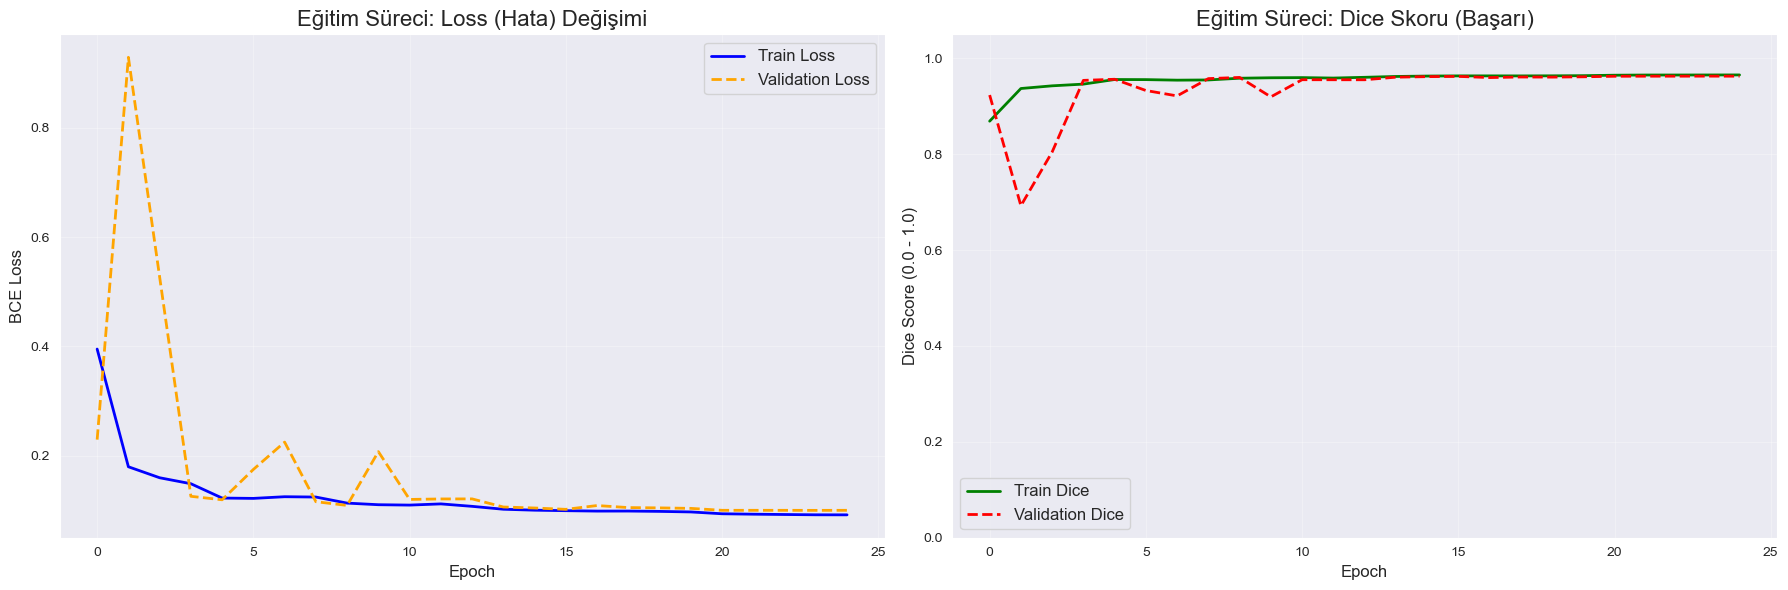

In [15]:
plt.figure(figsize=(18, 6))

# Loss 
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', color='orange', linestyle='--', linewidth=2)
plt.title('Eğitim Süreci: Loss (Hata) Değişimi', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('BCE Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Dice Score 
plt.subplot(1, 2, 2)
plt.plot(history['train_dice'], label='Train Dice', color='green', linewidth=2)
plt.plot(history['val_dice'], label='Validation Dice', color='red', linestyle='--', linewidth=2)
plt.title('Eğitim Süreci: Dice Skoru (Başarı)', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Dice Score (0.0 - 1.0)', fontsize=12)
plt.ylim(0, 1.05) 
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
def post_process_mask(pred_prob_map, threshold=0.5):
    binary_mask = (pred_prob_map > threshold).astype(np.uint8)

    kernel = np.ones((3, 3), np.uint8)
    opened_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=1)

    closed_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed_mask, connectivity=8)
    if num_labels > 1:
        sorted_indices = np.argsort(stats[1:, 4])[::-1]
        largest_indices = sorted_indices[:2] + 1
        final_mask = np.zeros_like(closed_mask)
        for idx in largest_indices:
            final_mask[labels == idx] = 1
        return final_mask
    
    return closed_mask

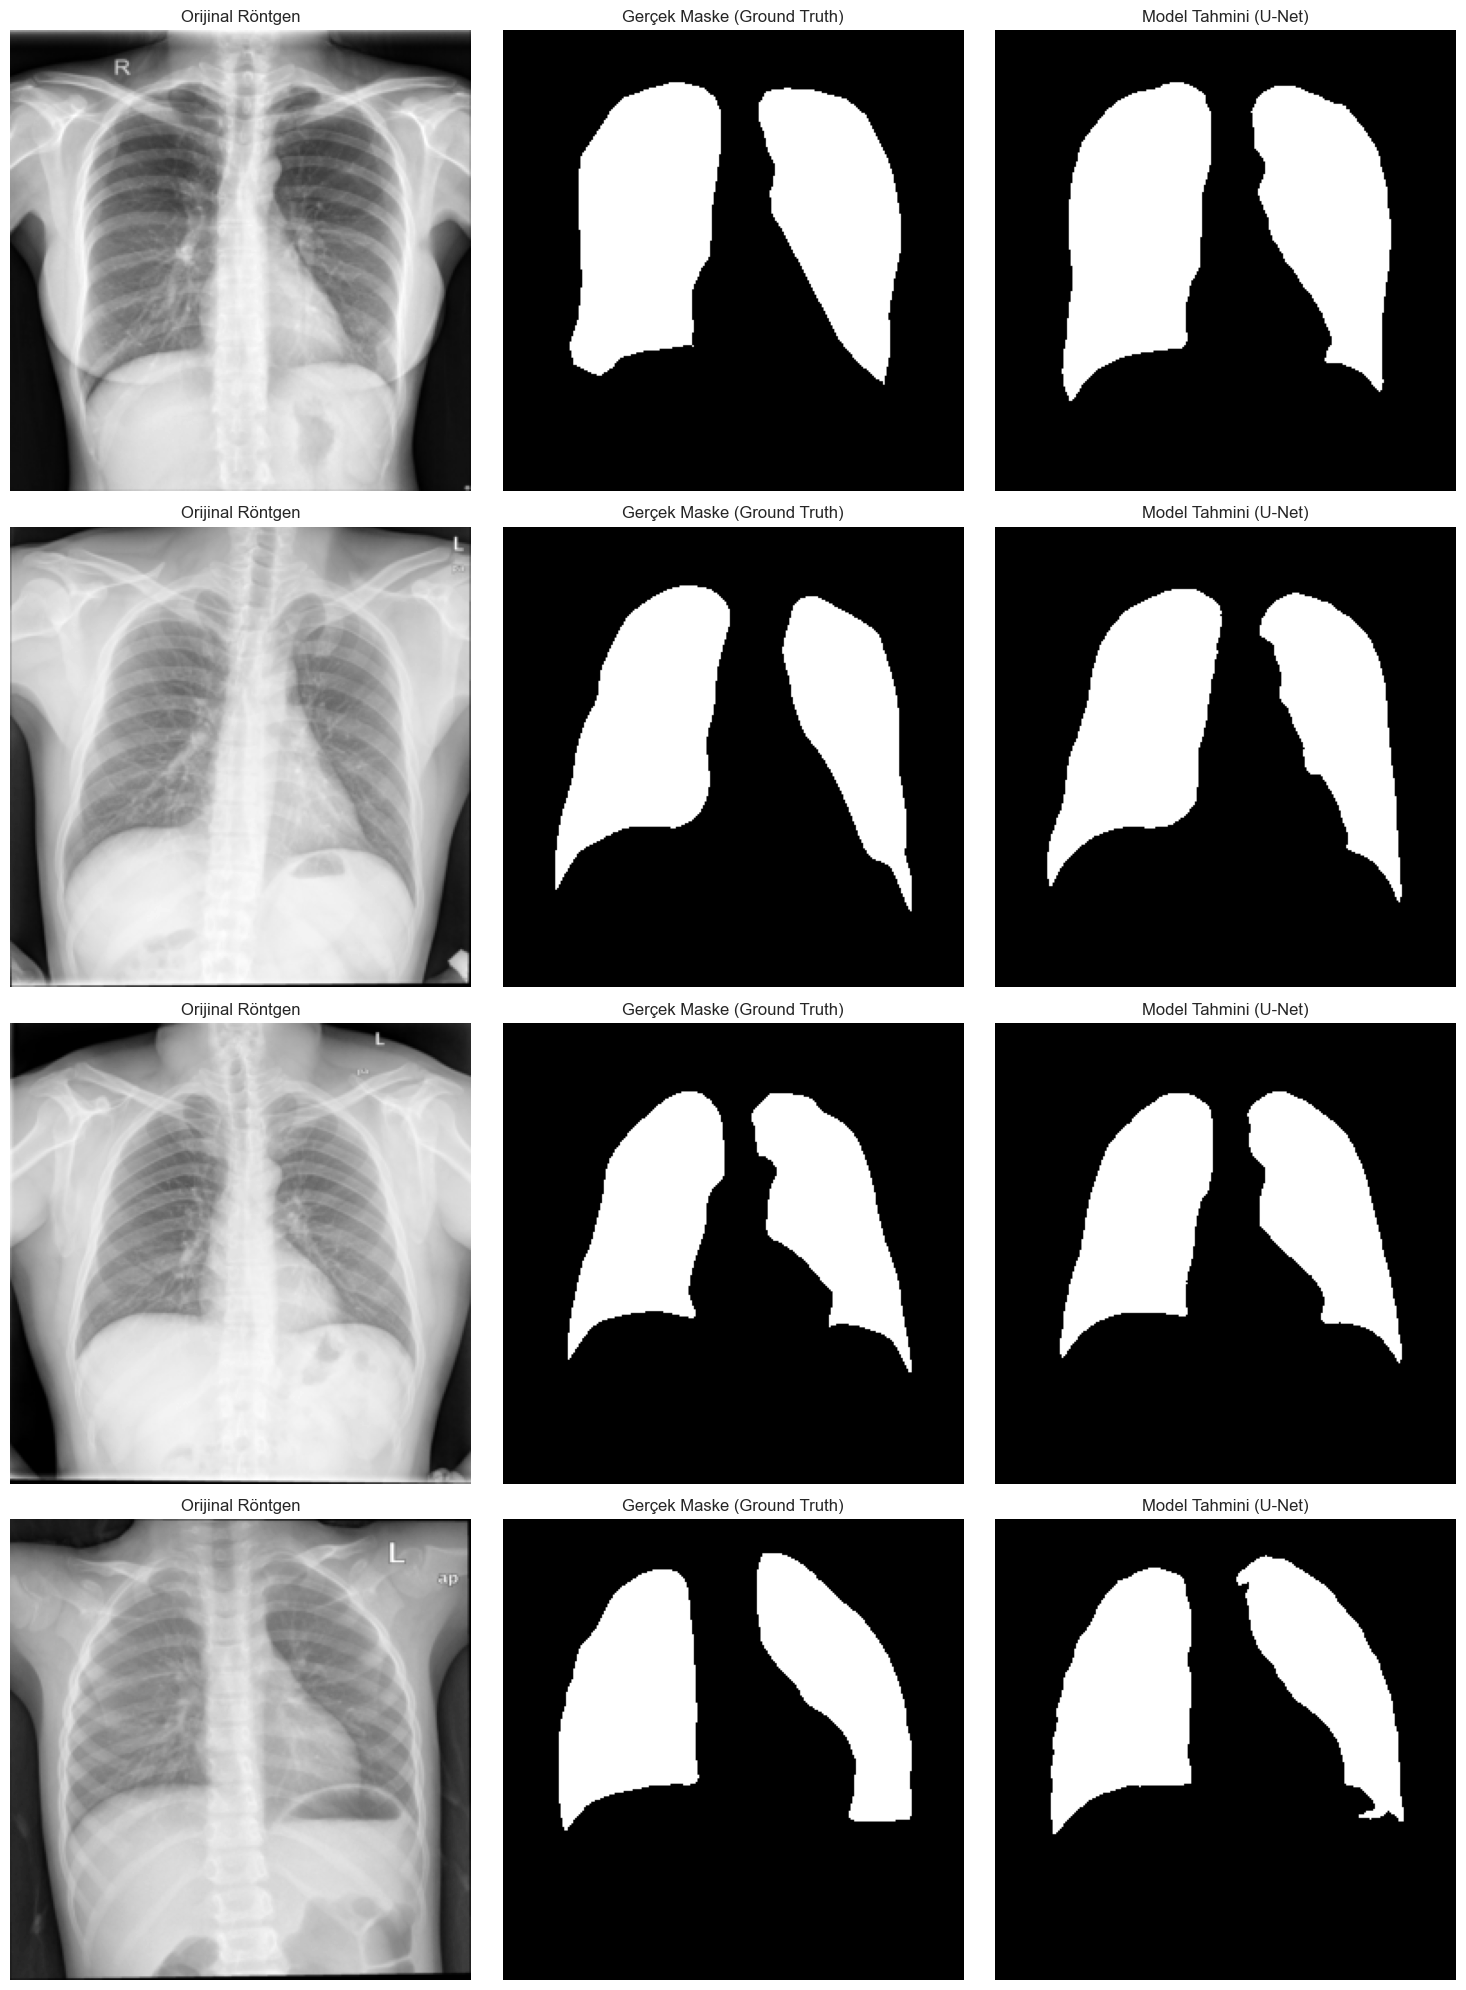

In [18]:
# TEST

def visualize_predictions(loader, model, num_samples=5):
    model.eval() 

    images, masks = next(iter(loader))
    
    images = images.to(device)
    
    with torch.no_grad():
        preds = model(images)
        preds = torch.sigmoid(preds) 
        preds = (preds > 0.5).float() 

    images = images.cpu()
    preds = preds.cpu()
    masks = masks.cpu()

    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        axs[i, 0].imshow(images[i].squeeze(), cmap='gray')
        axs[i, 0].set_title("Orijinal Röntgen")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(masks[i].squeeze(), cmap='gray')
        axs[i, 1].set_title("Gerçek Maske (Ground Truth)")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(preds[i].squeeze(), cmap='gray')
        axs[i, 2].set_title("Model Tahmini (U-Net)")
        axs[i, 2].axis('off')
        
    plt.tight_layout()
    plt.show()

visualize_predictions(val_loader, model, num_samples=4)

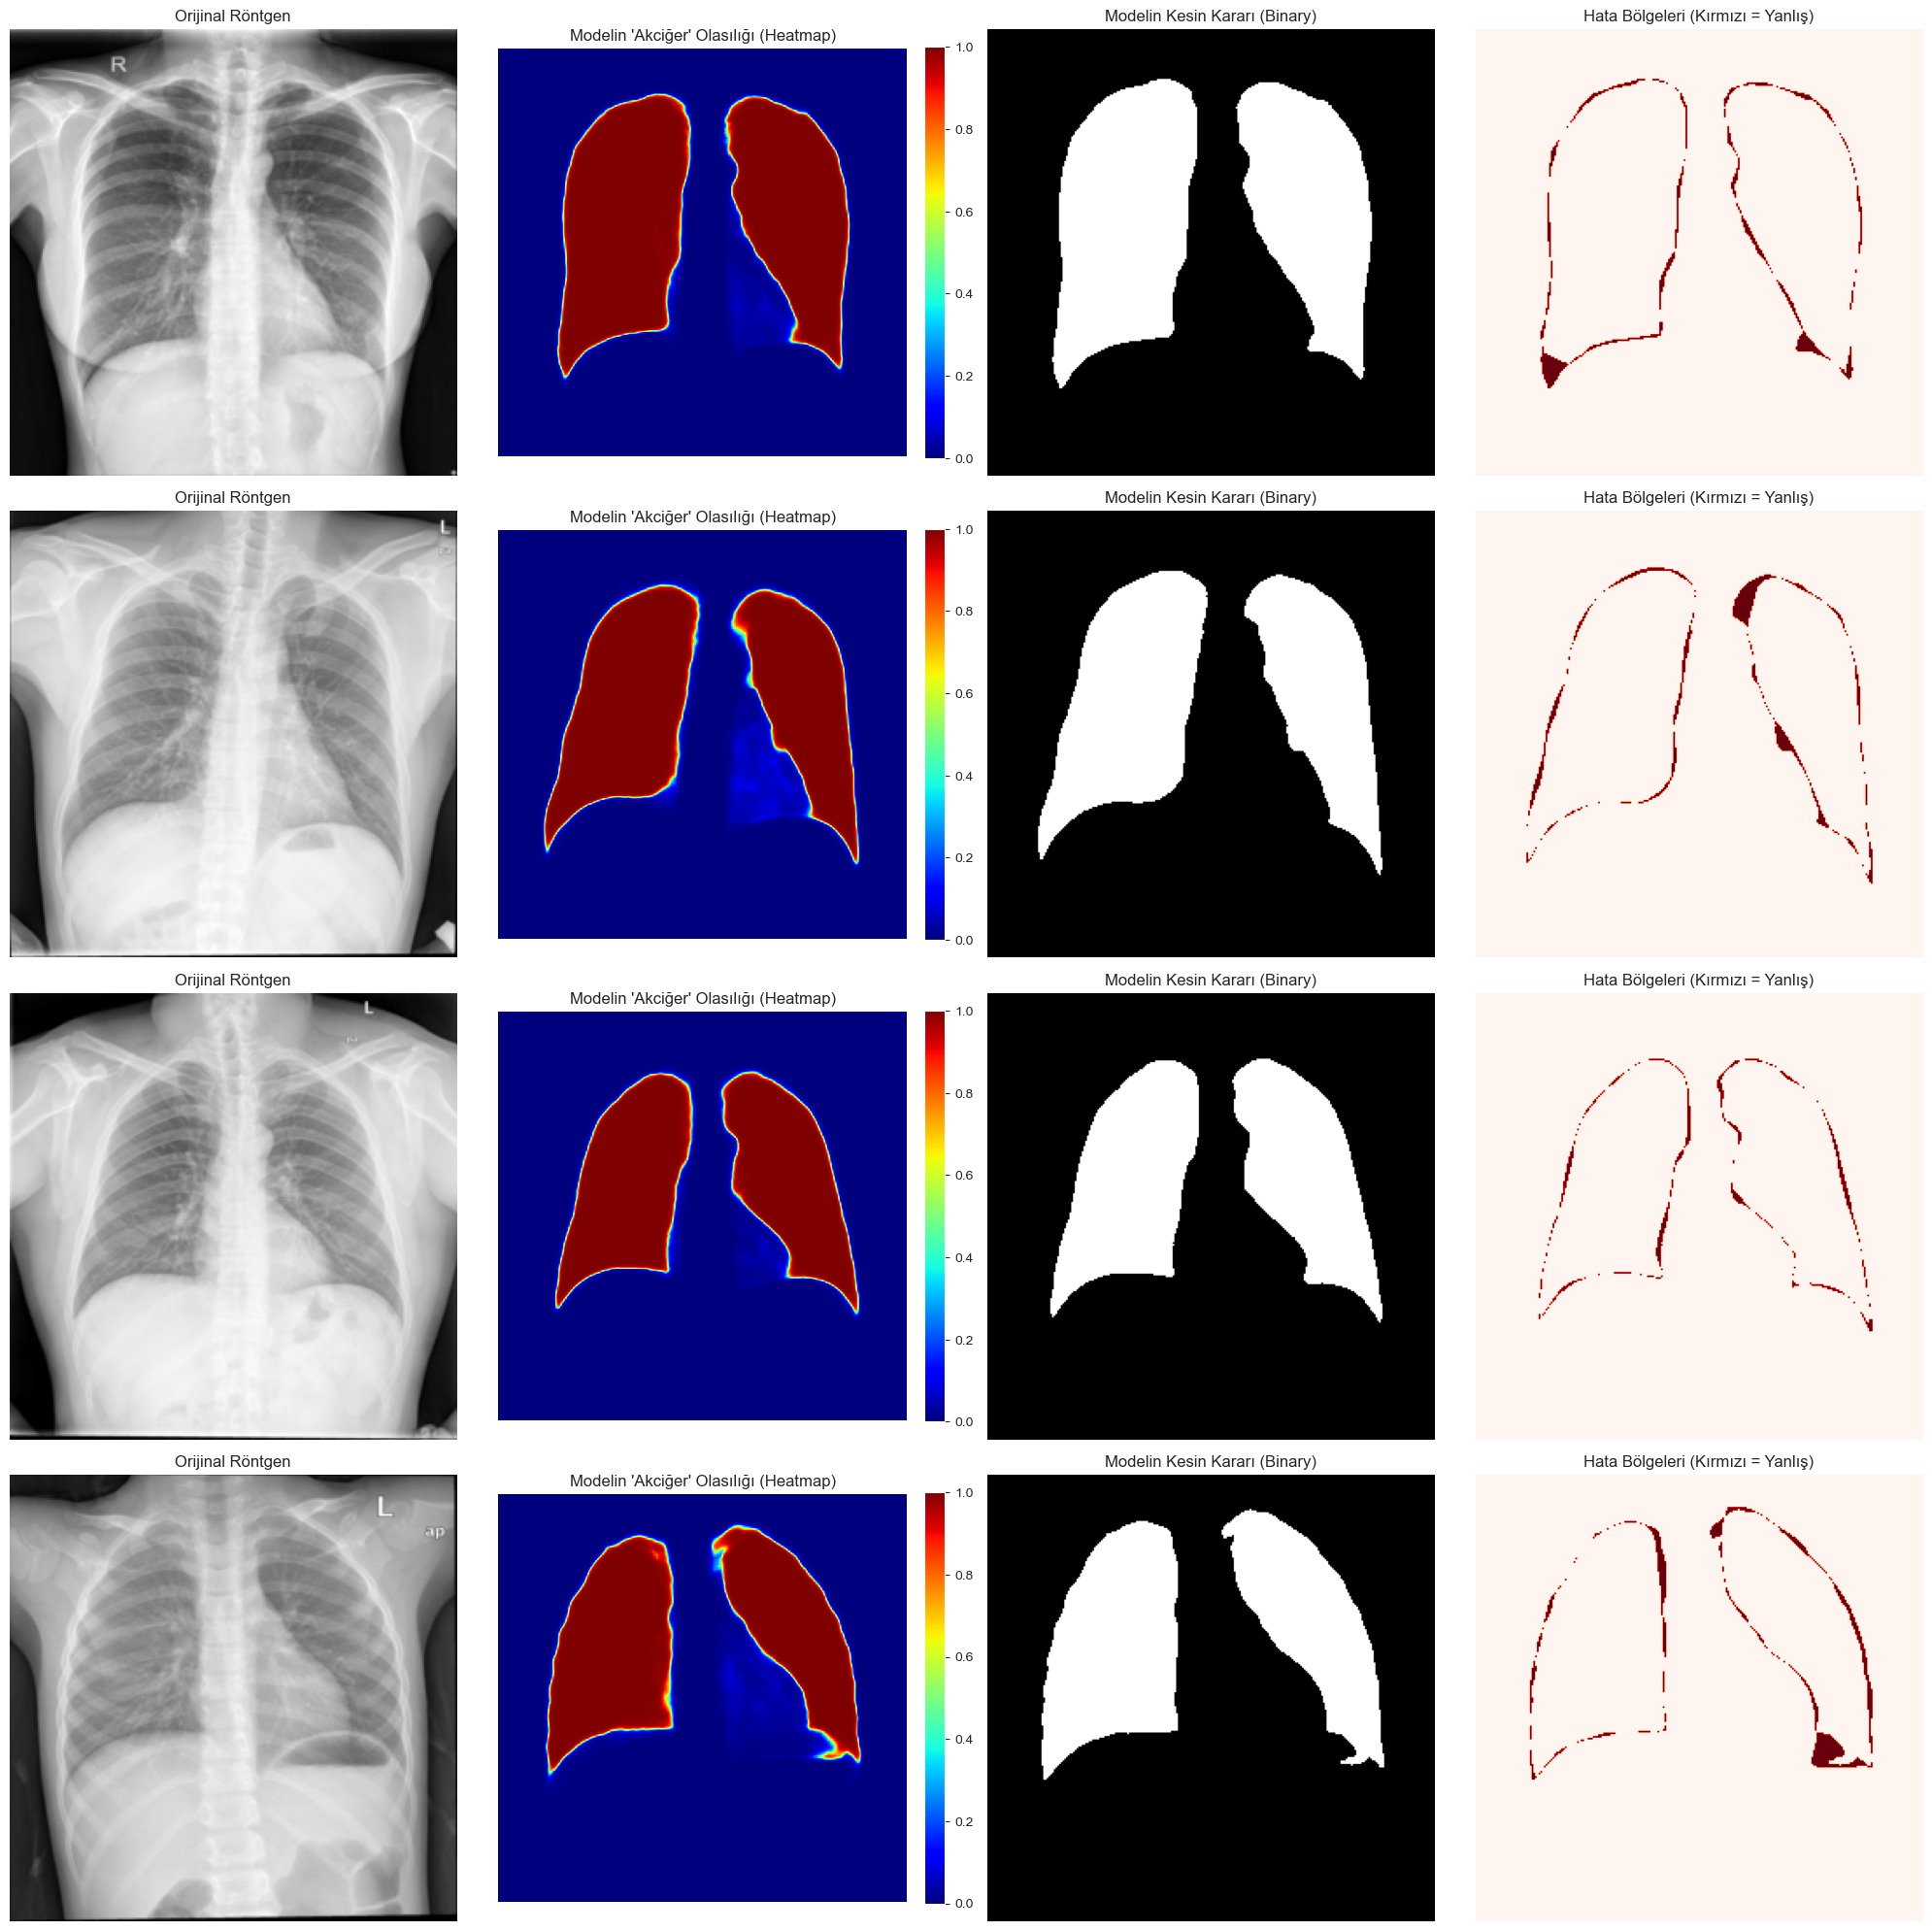

In [21]:
# Confidence Heatmap

def visualize_uncertainty(loader, model, num_samples=4):
    model.eval()
    images, masks = next(iter(loader))
    images = images.to(device)
    
    with torch.no_grad():
        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
    
    images = images.cpu()
    masks = masks.cpu()
    probs = probs.cpu()
    preds = preds.cpu()
    
    fig, axs = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    
    for i in range(num_samples):
        axs[i, 0].imshow(images[i].squeeze(), cmap='gray')
        axs[i, 0].set_title("Orijinal Röntgen")
        axs[i, 0].axis('off')

        im = axs[i, 1].imshow(probs[i].squeeze(), cmap='jet', vmin=0, vmax=1)
        axs[i, 1].set_title("Modelin 'Akciğer' Olasılığı (Heatmap)")
        axs[i, 1].axis('off')
        plt.colorbar(im, ax=axs[i, 1], fraction=0.046, pad=0.04)

        axs[i, 2].imshow(preds[i].squeeze(), cmap='gray')
        axs[i, 2].set_title("Modelin Kesin Kararı (Binary)")
        axs[i, 2].axis('off')

        error_map = torch.abs(masks[i] - preds[i])
        axs[i, 3].imshow(error_map.squeeze(), cmap='Reds', vmin=0, vmax=1)
        axs[i, 3].set_title("Hata Bölgeleri (Kırmızı = Yanlış)")
        axs[i, 3].axis('off')
        
    plt.tight_layout()
    plt.show()

visualize_uncertainty(val_loader, model)

In [23]:
# SAVE MODEL
ATTENTION_MODEL_PATH = 'attention_unet_lung_segmentation.pth'

torch.save(model.state_dict(), ATTENTION_MODEL_PATH)

In [24]:
def load_attention_unet_model(path, device):
    print(f"Model yükleniyor: {path}")

    model = AttentionUNet(n_channels=1, n_classes=1)

    model.load_state_dict(torch.load(path, map_location=device))
    
    model.to(device)
    model.eval()
    
    print("Attention UNet başarıyla yüklendi.")
    return model

# loaded_att_model = load_attention_unet_model('attention_unet_lung_segmentation.pth', device)